In [4]:
'''Imports'''
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
import numpy as np 
import math
import scipy.linalg as LA
from tqdm import tqdm
import time

# Linear Spin Chain Modelling 
Modelling the evolution of a linear spin chain for comparison of computational speed-up to the fermionic quadratic hamiltonian via the Jordan-Wigner transformation

Spin-chain Hamiltonian of form 
$$\hat{H}_{xy}=\sum^N_{n=1}\omega^z_n\hat{\sigma}^z_n + \sum^N_{n=1}\left[\left(\lambda^-_n\hat{\sigma}^-_n+\lambda^+_n\hat{\sigma}^+_n\right)\hat{\sigma}^+_{n+1}+\text{h.c.}\right]$$
where h.c. represents the Hermitian Conjugate of the preceeding term. 
For clarity, $\hat{\sigma}^z_n$ represents the tensor product of $N-1$ identities and a $\hat{\sigma}^z$ in the $n$-th position of the product. For example, the $\hat{\sigma}^z_2$ for a $N=4$ qubit system would look like:
$$\hat{\sigma}^z_2=I\otimes \hat{\sigma}^z \otimes I \otimes I$$

In [37]:
'''Functions'''
#Functions to generate the sigmas in the needed Hilbert space
def sigma_z_hilbert(current_term, dimension):
    #Set the pauli operators 
    sigma_z=np.array([[1,0],[0,-1]], dtype=complex)
    
    #Raise error for introducing index of 0
    if current_term==0 or current_term>dimension:
        error_msg='Error! Must provide term between 1 and N'
        return error_msg
        
    #Initialise the first term as the sigma_z if current n=1
    elif current_term==1:
        final_sig_z=sigma_z
        #iterate over the rest with identities to produce necessary size 
        for ii in range(1, dimension):
            final_sig_z=np.kron(final_sig_z, np.identity(2))
        return final_sig_z
            
    #Deal with the other cases where the term wanted is in the middle or end
    else:
        #Initialise as idenitiy for n=1 term outside of loop 
        final_sig_z=np.identity(2)
        
        #Loop over the other needed idenities from n=2 up until the sigma term
        for ii in range(1,current_term-1):
            final_sig_z=np.kron(final_sig_z, np.identity(2))
            
        #Now add the n=current_term sigma
        final_sig_z=np.kron(final_sig_z, sigma_z)
        
        #Finally loop again to get the rest of the needed identities
        for ii in range(current_term, dimension):
            final_sig_z=np.kron(final_sig_z, np.identity(2))
        return final_sig_z

def sigma_plus_hilbert(current_term, dimension):
    #Set the pauli operators 
    sigma_plus=np.array([[0,1],[0,0]], dtype=complex)
    
    #Raise error for introducing index of 0
    if current_term==0 or current_term>dimension:
        error_msg='Error! Must provide term between 1 and N'
        return error_msg
        
    #Initialise the first term as the sigma_ if current n=1
    elif current_term==1:
        final_sig_plus=sigma_plus
        #iterate over the rest with identities to produce necessary size 
        for ii in range(1, dimension):
            final_sig_plus=np.kron(final_sig_plus, np.identity(2))
        return final_sig_plus
            
    #Deal with the other cases where the term wanted is in the middle or end
    else:
        #Initialise as idenitiy for n=1 term outside of loop 
        final_sig_plus=np.identity(2)
        
        #Loop over the other needed idenities from n=2 up until the sigma term
        for ii in range(1,current_term-1):
            final_sig_plus=np.kron(final_sig_plus, np.identity(2))
            
        #Now add the n=current_term sigma
        final_sig_plus=np.kron(final_sig_plus, sigma_plus)
        
        #Finally loop again to get the rest of the needed identities
        for ii in range(current_term, dimension):
            final_sig_plus=np.kron(final_sig_plus, np.identity(2)) 
        return final_sig_plus    

def sigma_minus_hilbert(current_term, dimension):
    #Set the pauli operators 
    sigma_minus=np.array([[0,0],[1,0]], dtype=complex)
    
    #Raise error for introducing index of 0
    if current_term==0 or current_term>dimension:
        error_msg='Error! Must provide term between 1 and N'
        return error_msg
        
    #Initialise the first term as the sigma_ if current n=1
    elif current_term==1:
        final_sig_minus=sigma_minus
        #iterate over the rest with identities to produce necessary size 
        for ii in range(1, dimension):
            final_sig_minus=np.kron(final_sig_minus, np.identity(2))
        return final_sig_minus
            
    #Deal with the other cases where the term wanted is in the middle or end
    else:
        #Initialise as idenitiy for n=1 term outside of loop 
        final_sig_minus=np.identity(2)
        
        #Loop over the other needed idenities from n=2 up until the sigma term
        for ii in range(1,current_term-1):
            final_sig_minus=np.kron(final_sig_minus, np.identity(2))
            
        #Now add the n=current_term sigma
        final_sig_minus=np.kron(final_sig_minus, sigma_minus)
        
        #Finally loop again to get the rest of the needed identities
        for ii in range(current_term, dimension):
            final_sig_minus=np.kron(final_sig_minus, np.identity(2))
        return final_sig_minus
    

    

#Hamiltonian is now split into 3 components 
#Code each component and include a final function to sum them all 

#Hamiltonian of the system of interest 
def H_s(wx, wy, wz, dimension):
    H_s=(wx*(sigma_plus_hilbert(1, dimension)+1j*sigma_minus_hilbert(1, dimension))+ #Generate the sigma_x array
         wy*(sigma_plus_hilbert(1,dimension)-1j*sigma_minus_hilbert(1, dimension))+
         wz*(sigma_z_hilbert(1,dimension)))
    return H_s

#Hamiltonian of the environmental terms
def H_e(w_z_array, lam_plus_array, lam_minus_array, dimension):
    term_1=np.zeros((2**dimension, 2**dimension), dtype=complex)
    term_2=np.zeros((2**dimension, 2**dimension), dtype=complex)
    H_e=np.zeros((2**dimension, 2**dimension), dtype=complex)
    if dimension<2:
        pass
    else:
        for ii in range(2, dimension+1):
            term_1+=w_z_array[ii-1]*sigma_z_hilbert(ii, dimension) #Minus 1 to account for python indexing starting at 0
        for ii in range(2, dimension):
            term_2+=(lam_minus_array[ii-1]*sigma_minus_hilbert(ii, dimension)@sigma_plus_hilbert(ii+1, dimension)+
                     lam_plus_array[ii]*sigma_plus_hilbert(ii, dimension)@sigma_plus_hilbert(ii+1, dimension))
        #Complete sum of hamiltonian
        H_e=term_1 + term_2 + term_2.conj().T
    return H_e

#Hamiltonian of the interaction between the environment and the system
def V_se(lam_plus_1, lam_minus_1, lam_z_1, dimension):
    term=0+0j
    V_se=0+0j
    term+=(lam_minus_1*sigma_minus_hilbert(1, dimension)+
           lam_plus_1*sigma_plus_hilbert(1,dimension)+
           lam_z_1*sigma_z_hilbert(1,dimension))@sigma_plus_hilbert(2,dimension)
    #Sum for hamiltonian term
    V_se+=term+term.conj().T
    return V_se
    
#Complete Hamiltonian Function
def H_total(dimension, w_matrix, lam_matrix):
    return (H_s(w_matrix[0,0], w_matrix[0,1], w_matrix[0,2], dimension) +
            H_e(w_matrix[:,0], lam_matrix[:,0], lam_matrix[:,1], dimension) +
            V_se(lam_matrix[0,0], lam_matrix[0,1], lam_matrix[0,2], dimension))
        



    
#Initial state that needs to be evolved through time
#Given a Bloch vector nx ny nz and environment temperature 
def initial_state(nx, ny, nz, temperature, w_matrix, lam_matrix, dimension):
    len_state=np.sqrt(nx**2 + ny**2 + nz**2)
    if len_state>1:
        error_string='Error! The Bloch vector can at most be length 1, you entered a vector of length %f' % len_state
        return error_string
    else:
        #Need to generate the system state and the environment state 
        system_state=np.zeros((2,2), dtype=complex)
        environment_state=np.zeros((2**(dimension-1), 2**(dimension-1)), dtype=complex)
        #Placeholder for the total state 
        total_state=np.zeros((2**dimension, 2**dimension), dtype=complex)
        
        #Generate the system state
        system_state+=0.5*(np.identity(2, dtype=complex)+
                          nx*(sigma_plus_hilbert(1, 1)+1j*sigma_minus_hilbert(1, 1))+
                          ny*(sigma_plus_hilbert(1, 1)-1j*sigma_minus_hilbert(1,1))+
                          nz*sigma_z_hilbert(1, 1))
        
        #Placeholder for the environment state since the partition is just the trace of this 
        beta=1/temperature
        placeholder=LA.expm(-beta * H_e(w_matrix[:,0], lam_matrix[:,0], lam_matrix[:,1], dimension-1))
        partition=np.trace(placeholder)
        environment_state+=placeholder/partition
        
        #Now declare the final state
        total_state+=np.kron(system_state, environment_state)
        return total_state




#The time evolution unitary operator
def U(N, t):
    #Take hbar=1
    arg=1j*hamiltonian(N)*t
    #Exponentiate the matrix argument
    return LA.expm(arg)




#Function for evolving a state forward in time
#No need to do in time-steps since the Hamiltonian is time independent 
def evolve(N, initial_state, time):
    #Set the dimension of the space based on the initial state
    dim=N
    mat=U(dim, time)
    final_state=mat@initial_state
    final_state=final_state@(mat.conj().T)
    return final_state

# Beginning Simulation

Note that for the density matrix formulation, the expectation value of an operator $\hat{A}$given a desnity matrix $\rho$ describing the system at that time is given by:
$$ <\hat{A}>=Tr(\rho \hat{A}) $$ ,
where $Tr$ denotes the trace of the matrix.

## Post changing the exponentiation everything seems to be working. Follow the evolution of an operator through time to investigate the behaviour

Take the $\hat{\sigma}^{z}_1$ operator and see how it's expectation value evolves through time with the system. Given the above, we will have:
$$<\hat{\sigma}^{z}_1>=Tr(\hat{\rho}\hat{\sigma}^{z}_1)$$

In [3]:
#Number of qubits 
N=4

#Times for evolution
dt=0.01
times=np.arange(0,10+dt,dt)

#Array to hold values of sigma_z
sigma_zs=np.zeros(len(times))

#Store the value of sigma_z
sigma_z_1=sigma_z_hilbert(1,N)

#Generate the initial state
first_density=initial_state(N)

#Loop through each time to get the density matrix and find the associated expectation of sigma_z
for ii in range(len(times)):
    #Find the current density matrix by evolving the initial to the current timestep
    current_density=evolve(N, first_density, times[ii])
    #Find the expectation value using the trace
    sigma_zs[ii]=np.trace(current_density@sigma_z_1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5, 1.0, '\\hat{\\sigma}_1^z Expectation Value')

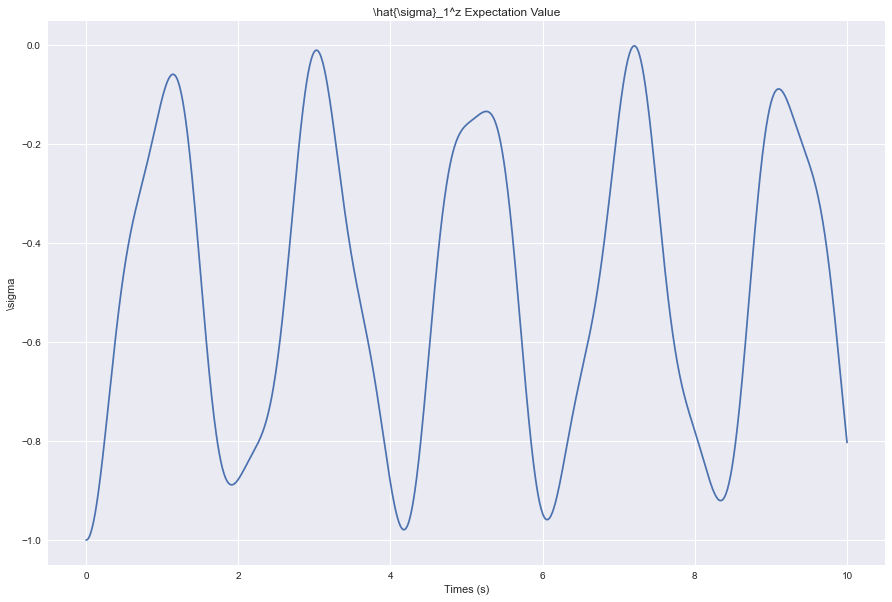

In [14]:
#Plotting 
plt.figure(figsize=(15,10))
plt.plot(times, sigma_zs)
plt.ylabel(r'\sigma')
plt.xlabel('Times (s)')
plt.title(r'\hat{\sigma}_1^z Expectation Value')

### Now create a function that will generate an array of expectation values of $\hat{\sigma}^z_1$ given the qubits in the system
We will use this to plot computation time vs number of qubits and hope to observe an exponential relationship

In [5]:
def sig_z_array(no_chain, qubits, times):
    #Array to hold values of sigma_z
    sigma_zs=np.zeros(len(times))

    #Store the value of sigma_z
    sigma_z_1=sigma_z_hilbert(no_chain, qubits)

    #Generate the initial state
    first_density=initial_state(qubits)

    #Loop through each time to get the density matrix and find the associated expectation of sigma_z
    for ii in range(len(times)):
        #Find the current density matrix by evolving the initial to the current timestep
        current_density=evolve(qubits, first_density, times[ii])
        #Find the expectation value using the trace
        sigma_zs[ii]=np.trace(current_density@sigma_z_1)
    return sigma_zs

### Start the timing 

In [7]:
#Create an array to hold qubit sizes 
qubits=np.arange(1,10,1)

#Create an array to hold computation times 
times_taken=np.zeros(len(qubits))

#Initialise dummy times to be used to compute the evolution of expectation values within the loop 
dt=0.01
times=np.arange(0,10+dt,dt)

#Loop through different qubit amounts and track time taken
for ii in tqdm(range(len(qubits))):
    #Start timing
    tick=tim3e.time()
    
    #Do the computation of evolution of the system
    sigz_placeholder=sig_z_array(1, qubits[ii], times)
    
    #Stop timing
    tock=time.time()
    
    #Store the time taken
    times_taken[ii]=tock-tick

  0%|          | 0/9 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
100%|██████████| 9/9 [20:48<00:00, 138.69s/it]


Text(0, 0.5, 'Time taken to evolve the system/s')

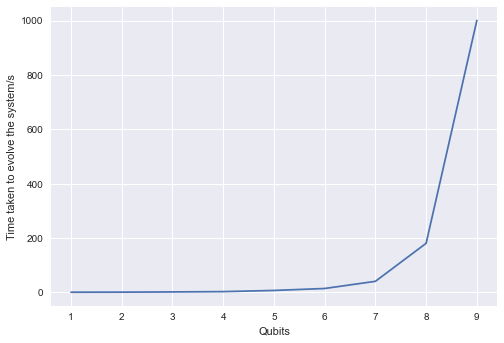

In [8]:
#Plotting results 
plt.plot(qubits, times_taken)
plt.xlabel('Qubits')
plt.ylabel('Time taken to evolve the system/s')

Text(0, 0.5, 'log_2(Time taken to evolve system/s)')

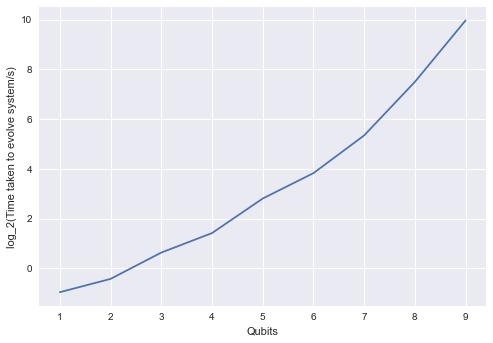

In [16]:
#Plotting to show exponential relationship
log_time=np.log2(times_taken)  #
plt.plot(qubits, log_time)
plt.xlabel('Qubits')
plt.ylabel(r'log_2(Time taken to evolve system/s)')

Try to see if this is quadratic in nature? 
Perhaps it is 
$$time=2^{n^2}$$
or, more generally
$$time=2^{n^k} \quad \text{where} \quad k\neq1$$
use logarithms to try to find this $k$ and see if $k=2$
This implies that 
$$log_2(times)=n^k$$
Implying that 
$$log_n(log_2(times))=k$$ 
which should produce a straight line graph. If not, suggests something wrong with the original base-2 assumption

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


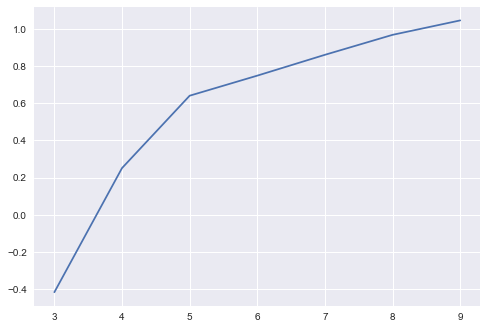

In [19]:
new_log_time=np.log(np.log2(times_taken))/np.log(qubits) #Produce a log to the base of the qubits
plt.plot(qubits, new_log_time)

The trace of the density matrix should always =1. Check during the evolution it stays that way

Computational complexity of matrix exponentiation? 